In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Bidirectional
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import keras
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [3]:
!ls

datasetCSV.zip		 DetectedAuthorTwitter.ipynb  LICENSE
datasetHabrahabr.csv	 DetectedAuthorVK.ipynb       model
dataset.zip		 echo_posts_100_and_more.csv  posts.csv
DetectedAuthorRNN.ipynb  Habrahabr		      README.md


In [4]:
# Устанавливаем seed для повторяемости результатов
np.random.seed(42)

In [13]:
N = 10
with open("echo_posts_100_and_more.csv") as myfile:
    head = [next(myfile) for x in range(N)]
print(head)

['|Author|Text\n', '0|ААВ-старший|"\n', '\n', 'Я\xa0сожалею, что начало передачи с\xa0Леонидом Волковым было скомкано. \n', '\n', 'Приношу извинения тем слушателям Эха, которые сочли этот инцидент неуместным  \n', '\n', '«Эхо Москвы» готово предложить дебаты между Ксенией Собчак и\xa0Алексеем Навальным.  \n', 'Оригинал "\n', '1|ААВ-старший|"\n']


In [5]:
data = pd.read_csv('echo_posts_100_and_more.csv', sep='|', engine='python', index_col=0)
data.head()

,Author,Text
0,ААВ-старший,"\n\nЯ сожалею, что начало передачи с Леонидом ..."
1,ААВ-старший,"\n\nПонятно, почему Путин рассказывал о высоко..."
2,ААВ-старший,"\n\nСчитал и считаю, что отказ в регистрации А..."
3,ААВ-старший,\nО странностях жизни. \nПутин благодарит Тра...
4,ААВ-старший,\n\nВот интересно – начальник Службы безопасно...


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87640 entries, 0 to 87436
Data columns (total 3 columns):
Author        87437 non-null object
Text          87640 non-null object
CountWords    87640 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [7]:
# data = pd.read_csv('posts.csv', names=['Author', 'Text'], sep=',', header=None)
# data.head()

In [94]:
#from nltk.corpus import stopwords
#stop = stopwords.words('russian')
#data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#print('Stop words have been deleted')
#data['Text'].apply(lambda x: x.replace('\n', ' '));

### Подсчет количества слов в корпусе

In [16]:
data.Text = data.Text.apply(str);

In [17]:
data['CountWords'] = data['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data))

Количество статей в корпусе: 87640


### Удаление спам пользователей

In [96]:
spam_list = [301557842, 184330667, 191315693, 111604181, 212846761, 278053852, 281162155, 206300456, 306859957, 19006413, 275267400, 131629784, 276695686, 227968805, 65265920, 215657793, 212066696, 281866527, 172515637, 420657548, 259904924, 103086082, 36309849, 151622711, 304407589, 304407589, 234135027, 330779808, 135431520, 326927985, 22070189, 16497456, 22070189, 16497456, 120772826, 181255568, 24655736, 90966607, 102977537, 317336618, 189704404, 11663845, 57439210, 163452787, 38680483, 121144040, 211289578, 280155968, 198528079, 277512341, 33152119, 314327791, 229101154, 271546215, 4121239, 59729051, 288393060, 17620663, 296431137, 320666372, 153340241, 13309210, 333014765, 24595847, 152263680, 135815313, 27763994, 34902711, 200488318, 393710429, 400853612, 18091069, 232368999, 243123251, 159034443, 101820061, 334397479, 36372315, 18412482, 362494239, 98538332, 94983825, 171941220, 35386477, 179364423, 136668179, 57446172, 288223392, 321431512, 277994902, 190694040, 325021098, 129392296, 289027630, 216216545, 75884932, 208023062, 185965346, 2857932, 2574325, 154034429, 312715518, 286913827, 336049060, 163410643, 309938895, 372204020, 400615680, 235441786, 8391421, 136997064, 174934251, 173179778, 134275738, 93070783, 403039516, 326194938, 26960550, 18090797, 15931375, 64401851, 14665799, 223678239, 1963998, 252135842, 16352364, 386230491, 135103805, 335233013, 226605259, 94018354, 363143703, 278775919, 134780377,498638, 498638, 20403116, 824871, 22259914, 203601767, 386435681, 280519165, 225577927, 336493264, 203836012, 250362235, 135154139, 332671406, 296879545, 191398452, 48411613, 276175277, 77459397, 15155303, 6646818, 174692652, 25755928, 145799445, 210213078, 225680585, 167783297, 159347782, 154637631, 343704548, 276329737, 158954181, 7736592, 52430830, 54738353, 181641220, 249065698, 356566757, 12276180, 146475131, 38034256, 301152537, 181250759, 65169740, 229445819, 360098848, 204181735, 311981137, 9365217, 323032519, 144081373, 166471693, 219977388, 3252582, 92645976, 341675206, 394122042, 8469671, 293599275, 150564713, 315874927, 75299334, 395839270, 256327432, 8758868, 234523373, 234523373] 
print('Count of spam users:', len(spam_list))
lam = lambda row: row['Author'] not in spam_list
data = data[data.apply(lam, axis=1)]

Count of spam users: 201


In [19]:
author_count_news = data.Author.value_counts()
print('Количество авторов в корпусе:', len(author_count_news))
#print(author_count_news[:-8300: -1])
#author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

Количество авторов в корпусе: 290


### Количество статей у каждого пользователя

In [20]:
# Попробовать изменить количество статей у автора, у каждого 10 постов, 50, 100

num_classes = 50
skip_person = 5
author_count_news_dubset = author_count_news[skip_person:skip_person+num_classes]

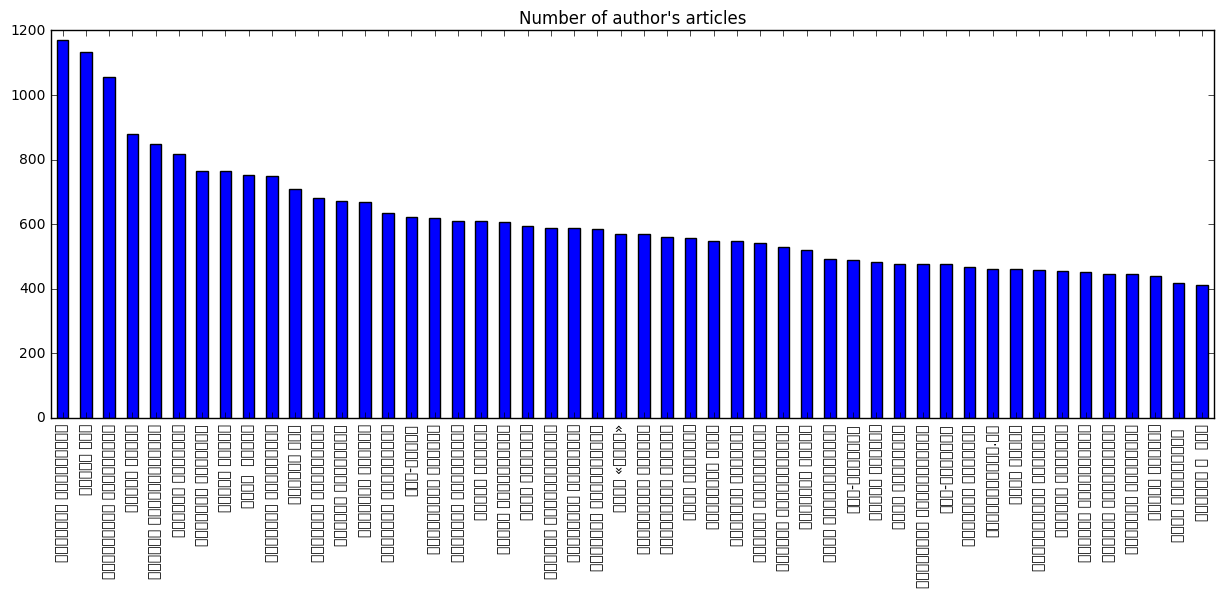

In [21]:
author_count_news_dubset.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

In [100]:
for i, (user_id, number) in enumerate(author_count_news.items()):
    print('User id', user_id)
    print(data[data.Author == user_id]['Text'][:2])
    print('===========')
    if i == 2:
        break

User id 2023105
2024    – Разве хегзы, это не те, кто взывает к легенд...
2025    — «Shoryuken» means «rising dragon fist», appa...
Name: Text, dtype: object
User id 225897827
70147    ✨✨ МОЙ МИР РАДУЕТ МЕНЯ СВОИМ ИЗОБИЛИЕМ И РАЗНО...
70148    "Мой новый взгляд на прощение или как я учусь ...
Name: Text, dtype: object
User id 82145315
32365    "... Полностью войдите в роль любителя, которы...
32366    "... Что бы мы ни говорили, что бы ни делали, ...
Name: Text, dtype: object


### Подготовка данных

In [24]:
temp_data = pd.DataFrame()
names_author = author_count_news_dubset.index.values

for author in names_author:
    temp_data = temp_data.append(data[data.Author == author])

data = temp_data
print('Количество статей после удаления:', len(data))

Количество статей после удаления: 30475


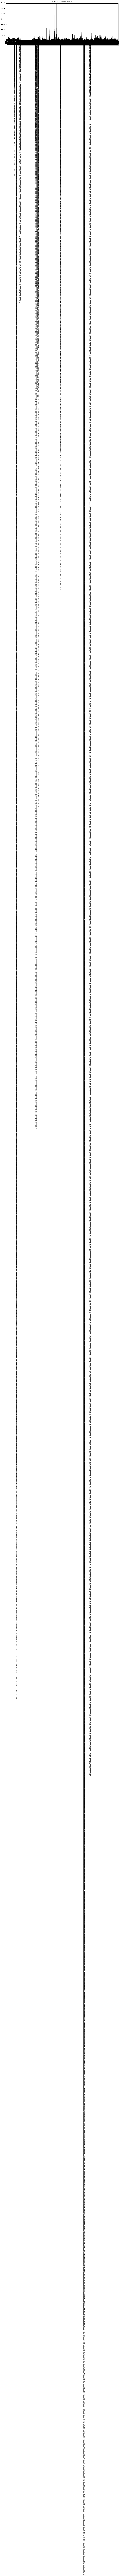

In [22]:
data.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

In [102]:
# def remove_stopwords(data):
#     from nltk.corpus import stopwords
#     stop = stopwords.words('russian')
#     data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#     print('Stop words have been deleted')

In [103]:
# def get_lemmatization_corpus(data):
#     import pymorphy2
#     morph = pymorphy2.MorphAnalyzer()
#     data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
#     print('The lemmatization completed')

In [25]:
names = data.Author.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

for author in names:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data.head()

,Author,Text,CountWords
49703,6,"«Левада-центр», среди\n\nмногих других полезны...",529
49704,6,Избирательные штабы Г.А. Явлинского\n\n в 79 р...,453
49705,6,Ушедший из жизни Виктор Иванович\n\nАнпилов бы...,376
49706,6,Сказанное ниже не относится к избирателям\n\n...,542
49707,6,"Впечатление такое, что\n\nте, кто не хочет гол...",256


In [26]:
# Перемешать набор данных и удалить index столбец
data = data.sample(frac=1).reset_index(drop=True)

### Токенизация текста

In [27]:
def get_texts_to_matrix(texts, max_features = 0):
    tokenizer = Tokenizer(split=" ", lower=True)
    if max_features != 0:
        tokenizer = Tokenizer(split=" ", lower=True, num_words=max_features)
    
    tokenizer.fit_on_texts(texts)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
    print('Количество текстов:', matrix_tfidf.shape[0])
    print('Количество токенов:', matrix_tfidf.shape[1])
    return matrix_tfidf

In [28]:
# Убрать LowerCase

def get_texts_to_sequences(text):
    # создаем единый словарь (слово -> число) для преобразования
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    # Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
    text_sequences = tokenizer.texts_to_sequences(text)
    print('В словаре {} слов'.format(len(tokenizer.word_index)))
    return text_sequences

In [69]:
def get_texts_to_gramm_sequences(texts, count_gramm = 3):
    gramms = {}
    gram_id = 0
    result = []
    for text in texts:
        temp_vector = []
        count_grams_for_text = range(len(text) - count_gramm - 1)
        for i in count_grams_for_text:
            gramm = text[i : i + count_gramm]
            if gramm not in gramms:
                gramms[gramm] = gram_id
                gram_id += 1
            temp_vector.append(gramms[gramm])
        result.append(temp_vector)
    print('Количество грамм в корпусе:', len(gramms))
    return result

In [48]:
#X = get_texts_to_matrix(data['Text'], 80000)
#X = get_texts_to_gramm_sequences(data['Text'])
#X = get_texts_to_sequences(data['Text'])

In [71]:
X_gram_3 = get_texts_to_gramm_sequences(data['Text'], count_gramm = 3)
X_gram_4 = get_texts_to_gramm_sequences(data['Text'], count_gramm = 4)
X_seq = get_texts_to_sequences(data['Text'])

Количество грамм в корпусе: 150961
Количество грамм в корпусе: 762583
В словаре 1068661 слов


In [32]:
array_X = [X_gram_3, X_gram_4, X_seq]

In [47]:
def print_plot_mean(x):
    means = [len(x) for x in x]
    plt.plot(means);

In [55]:
len(X_gram_3[0])
#print_plot_mean(X_gram_3)
#print_plot_mean(X_gram_4)
#print_plot_mean(X_seq)

1747

In [53]:
X = X_gram_3

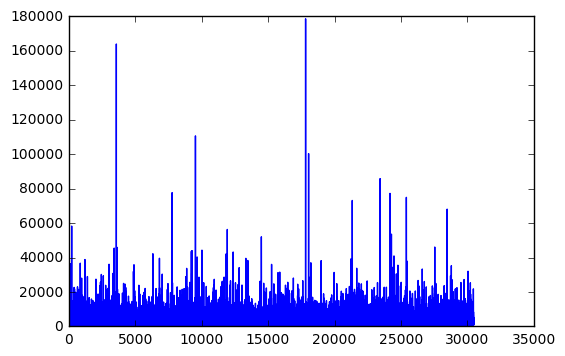

In [54]:
#plt.plot(X)
means = [len(x) for x in X]
plt.plot(means);
#X.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

### Разбиваем выборку на тестовую и тренировочную

In [72]:
def get_X_y_for_traning(X, y, num_words):
    #tokenizer = Tokenizer(num_words=num_words)
    #X = tokenizer.sequences_to_matrix(X, mode='binary')

    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=num_words)     
    y = keras.utils.to_categorical(y, num_classes)
    print('Размерность X:', X.shape)
    print('Размерность y:', y.shape)
    return X, y

In [76]:
# Максимальное количество слов в самом длинном тексте
num_words = 20000
# X_full, y_full = get_X_y_for_traning(X_gram_3, data.Author, num_words)
# X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
array_sets = []
X_full, y_full = get_X_y_for_traning(X_gram_3, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

X_full, y_full = get_X_y_for_traning(X_gram_4, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

num_words = 2500
X_full, y_full = get_X_y_for_traning(X_seq, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

#print('Testing set size:', len(X_test))
#print('Training set size:', len(X_train))

Размерность X: (30475, 20000)
Размерность y: (30475, 50)
Размерность X: (30475, 20000)
Размерность y: (30475, 50)
Размерность X: (30475, 2500)
Размерность y: (30475, 50)


### Accuracy в зависимости от параметров Dropout
![alt text](https://2.downloader.disk.yandex.ru/preview/8e14c7756af3174dd350c25f3e6b8440a61e9a777ee2da314fd9f7fdd3091b2f/inf/rO8FnfsfSlEfAA1AjPLcJ2uQGpv-ZqVMnu5RumfWpo4yKYIGlxh3eJRayw6TcMCHwESHEemqBkkmTZnnheB-xQ%3D%3D?uid=0&filename=2018-02-04_19-53-32.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&tknv=v2&size=XXL&crop=0 "Logo Title Text 1")

### Accuracy в зависимости от Learning Rate
![alt text](https://2.downloader.disk.yandex.ru/preview/fa7057505b329e83b102d9815718569bd8495582c48d5fbe83bc35b0615263ce/inf/rO8FnfsfSlEfAA1AjPLcJ3LSAMr9nlqY5MHCpTZ2V9rMkRavocK8rFQ9rEwG9gspdkhMcLPBICDpAd1YRkHHlw%3D%3D?uid=0&filename=2018-02-04_19-54-48.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&tknv=v2&size=XXL&crop=0 "Logo Title Text 1")

### Accuracy в зависимости от Batch size
![alt text](https://4.downloader.disk.yandex.ru/disk/8eb281727507e6d15620d94175cec3ed4f509b3c40e5a820a1044c1e989e2dda/5a775771/rO8FnfsfSlEfAA1AjPLcJ6926tWJn_ypr-A-mql52eNcQXSffjilIJqUiUafRUZuc-1sR5I9yDwgiCUs2xFu6g%3D%3D?uid=0&filename=2018-02-04_19-56-28.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&fsize=29996&hid=308d82806a74c28ee7ee9c1432dbc6ba&media_type=image&tknv=v2&etag=849c2457f9719ab80079d07e58f899d9 "Logo Title Text 1")


### Создание модели нейронной сети

In [54]:
def get_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(input_length, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
def get_bidirectional_lstm():
    model = Sequential()
    model.add(Embedding(80000, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(10, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
def get_conv_conv_model():
    model = Sequential()
    model.add(Embedding(160000, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
def get_conv_lstm_model():
    model = Sequential()
    #model.add(Dense(102562, activation='relu', input_shape=(8664, 600)))
    model.add(Embedding(100000, 200))
    model.add(SpatialDropout1D(0.3))
    #model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu')))
    #model.add(TimeDistributed(GlobalMaxPooling1D()))
    #model.add(TimeDistributed(Flatten()))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    #model.add(Flatten())
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
def get_lstm_conv_model():
    model = Sequential()
    model.add(Embedding(160000, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)) 
    #model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='sigmoid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [74]:
def get_conv_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
hist_array = []
for i, (X_train, X_test, y_train, y_test) in enumerate(array_sets):
# Количество грамм в корпусе: 150961
# Количество грамм в корпусе: 762583
# В словаре 1068661 слов
    if i == 0:
        model = get_conv_model(embeding_size=150961) # 53.1 6-epoch
    if i == 1:
        model = get_conv_model(embeding_size=762583) # 53.1 6-epoch
    if i == 2:
        model = get_conv_model(embeding_size=1068661) # 53.1 6-epoch
        
    model.summary()

    BATCH_SIZE = 32
    EPOCHS = 7
    VERBOSE = 2

    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS, verbose=VERBOSE,
                        validation_data=(X_test, y_test)
                        #validation_split=0.1, 
                        #callbacks=[EarlyStopping(monitor='val_loss')]
                       )
    hist_array.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         30192200  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25650     
Total params: 30,525,562
Trainable params: 30,525,562
Non-trainable params: 0
_________________________________________________________________
Train on 24380 samples, validate on 6095 samples
Epoch 1/7
1023s - loss: 1.6093 - acc: 0.5867 - val_loss: 0.7306 - val_acc: 0.7974

/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 152516600 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 24380 samples, validate on 6095 samples
Epoch 1/7
1072s - loss: 1.5359 - acc: 0.6050 - val_loss: 0.6644 - val_acc: 0.8162
Epoch 2/7
1070s - loss: 0.4048 - acc: 0.8896 - val_loss: 0.5179 - val_acc: 0.8546
Epoch 3/7
1069s - loss: 0.1541 - acc: 0.9618 - val_loss: 0.5150 - val_acc: 0.8573
Epoch 4/7
1073s - loss: 0.0518 - acc: 0.9886 - val_loss: 0.4451 - val_acc: 0.8815
Epoch 5/7
1070s - loss: 0.0302 - acc: 0.9917 - val_loss: 0.4354 - val_acc: 0.8847
Epoch 6/7
1072s - loss: 0.0261 - acc: 0.9918 - val_loss: 0.4402 - val_acc: 0.8863
Epoch 7/7
1072s - loss: 0.0248 - acc: 0.9920 - val_loss: 0.4570 - val_acc: 0.8853
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         213732200 
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 200)         0         
_______________________________________________

/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 213732200 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 24380 samples, validate on 6095 samples
Epoch 1/7
274s - loss: 2.0719 - acc: 0.4529 - val_loss: 1.1253 - val_acc: 0.6902
Epoch 2/7
266s - loss: 0.6856 - acc: 0.8143 - val_loss: 0.8213 - val_acc: 0.7728
Epoch 3/7
266s - loss: 0.1521 - acc: 0.9702 - val_loss: 0.7600 - val_acc: 0.7895
Epoch 4/7
266s - loss: 0.0368 - acc: 0.9906 - val_loss: 0.7235 - val_acc: 0.7972
Epoch 5/7
266s - loss: 0.0273 - acc: 0.9915 - val_loss: 0.7246 - val_acc: 0.8013
Epoch 6/7
266s - loss: 0.0244 - acc: 0.9915 - val_loss: 0.7339 - val_acc: 0.8000
Epoch 7/7
266s - loss: 0.0235 - acc: 0.9919 - val_loss: 0.7513 - val_acc: 0.7975


In [79]:
len(hist_array)

3

In [ ]:
%%time
#model = get_lstm_model(120000) # 34.10 10-epoch
#model = get_bidirectional_lstm() # 50.86 20-epoch
model = get_conv_model() # 53.1 6-epoch
#model = get_conv_conv_model() # 54.04 7-epoch
#model = get_conv_lstm_model() # 53.17 10-epoch
#model = get_lstm_conv_model() # 52.60 10-epoch

model.summary()

BATCH_SIZE = 32
EPOCHS = 7
VERBOSE = 2

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=VERBOSE, 
                    validation_split=0.1, 
                    #callbacks=[EarlyStopping(monitor='val_loss')]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         30192200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                25650     
Total params: 30,525,562
Trainable params: 30,525,562
Non-trainable params: 0
_________________________________________________________________
Train on 21942 samples, validate on 2438 samples
Epoch 1/7
880s - loss: 1.6866 - acc: 0.5625 - val_loss: 0.8000 - val_acc: 0.7834


In [59]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=64, verbose=2)[1] * 100))

Точность модели составляет: 88.3182937009497


dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


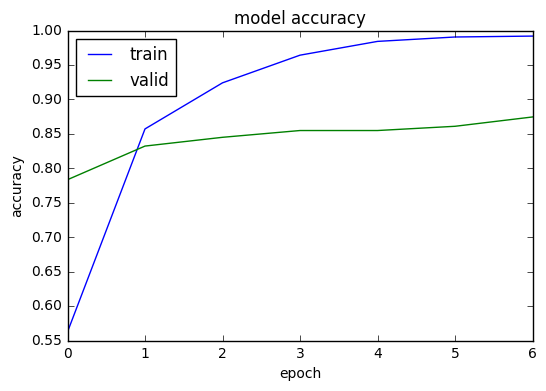

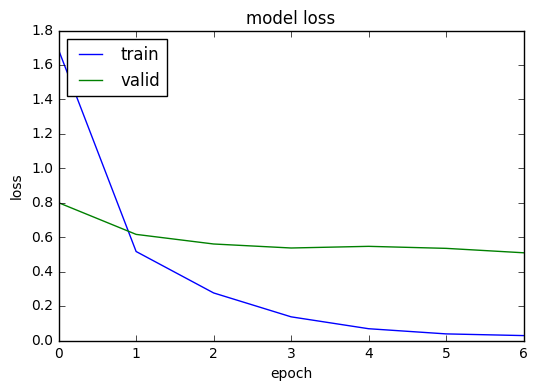

In [60]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

In [44]:
def save_model(model, model_name):
    # Генерируем описание модели в формате json
    model_json = model.to_json()
    # Записываем модель в файл
    json_file = open("model/{}_model.json".format(model_name), "w")
    json_file.write(model_json)
    json_file.close()
    model.save_weights("model/{}_weights.h5".format(model_name))
    print('Модель и веса успешно сохранены!')

In [58]:
save_model(model, 'vk_98percent_cnn')

Модель и веса успешно сохранены!
